In [1]:
import time
import mysql.connector
from mysql.connector import errorcode
import pandas as pd
import re
import os
import numpy as np
import matplotlib.pyplot as plt
import nltk
import config as cfg
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download("sentiwordnet")
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tiitu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tiitu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tiitu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     C:\Users\tiitu\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


Ratio of medical terms to total words: 0.46153846153846156
Ratio of medical terms to total words before preprocessing: 0.36
2: Ratio of medical terms to total words: 0.4153846153846154
2: Ratio of medical terms to total words before preprocessing: 0.3


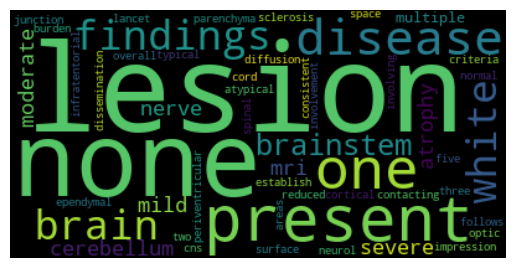

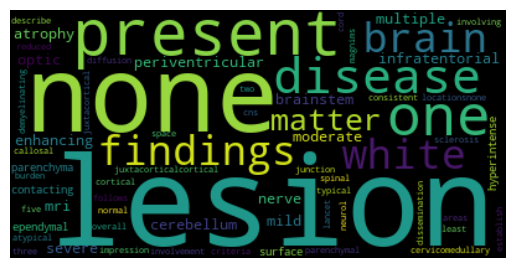

Words in original report but not in medical terms:


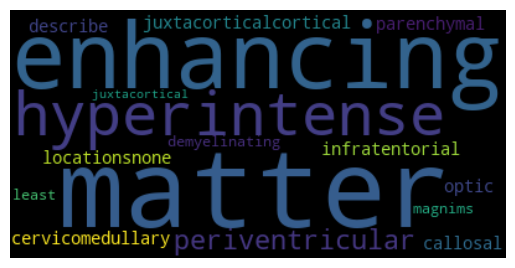

In [19]:
# Use mysql to connect to the "metathesaurus" local database

# Connect to the database
username = 'root'
password = 'azyti5hy'
host = 'localhost'
database = 'metathesaurus'
port = '3600'

stop_words = set(stopwords.words('english'))

def preprocess_words(text):
    if type(text) != str:
        return []
    text = text.replace(',', '')
    text = text.replace(".", '')
    text = text.lower()
    text = text.replace('(', '')
    text = text.replace(')', '')
    text = text.replace('.', '')
    text = text.replace(';', '')
    text = text.replace(':', '')
    text = text.replace('?', '')
    text = text.replace('!', '')
    text = text.replace('-', '')
    text = text.replace('[', '')
    text = text.replace(']', '')
    text = text.replace('{', '')
    text = text.replace('}', '')
    text = text.replace('<', '')
    text = text.replace('>', '')
    text = text.replace('/', '')
    text = text.replace('\\', '')
    text = text.replace('_', '')
    text = text.replace('%', '')
    # Remove quotation marks
    text = text.replace('"', '')
    text = text.replace("'", '')
    # Sometimes pipe symbol separates two words, so replace it with a space
    text = text.replace('|', ' ')

    # Remove words including numbers or special characters using regular expressions
    text = re.sub(r'\w*\d\w*', '', text)

    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return filtered_words

def semantic_type_grouper(semantic_types):
    return " OR ".join(["s.STY LIKE '%" + semantic_type + "%'" for semantic_type in semantic_types])

## Queries the metathesaurus vocabulary for a list of medical terminology used in the given string, with a simple string match
def find_medical_terms(string, preprocess=True, semantic_types=[], remove_duplicates=True):
    # Connect to the database
    cnx = mysql.connector.connect(user=username, password=password, host=host, database=database, port=port)
    cursor = cnx.cursor()

    # First, tokenize with nltk
    tokens = nltk.word_tokenize(string)
    # Lemmatize the tokens
    lemmatizer = nltk.stem.WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    tokens = " ".join(tokens)
    
    # Query the database for each word in the string
    medical_terms = []
    if len(semantic_types) > 0:
        semantic_q = " AND " + semantic_type_grouper(semantic_types)
        query = 'SELECT COUNT(*) FROM MRCONSO m, MRSTY s WHERE m.STR = "{}" AND m.cui = s.cui AND (m.TTY LIKE "MH%" OR m.TTY LIKE "PT%" OR m.TTY LIKE "SY%")' + semantic_q
    else:
        query = 'SELECT COUNT(*) FROM MRCONSO WHERE STR = "{}"'

    if preprocess:
        words = preprocess_words(string)
    else:
        words = string.split()
    for word in words:
        # Query the database for the word. If the word appears in the database, add it to the list of medical terms
        q = query.format(word)
        cursor.execute(q)
        if remove_duplicates:
            if cursor.fetchone()[0] > 0 and word not in medical_terms:
                medical_terms.append(word)
        else:
            if cursor.fetchone()[0] > 0:
                medical_terms.append(word)
    return medical_terms

test_report_1 = """FINDINGS:
BRAIN PARENCHYMA:
T2 hyperintense white matter lesions:
*Periventricular: [No|1-2|3 or more] lesions contacting the ependymal surface
*Juxtacortical/Cortical: [None|Present]
*Infratentorial: [None|Present involving the [brainstem cerebellum brainstem and
cerebellum]]
*Optic Nerve: [None|Present]
*Cervicomedullary Junction: [None|Present]
Enhancing Lesions: [<# of enhancing lesions and locations>None]
Reduced Diffusion: [None|Present (describe)]
Overall Disease Burden: [None|<10 lesions 10-20 lesions |>20 lesions]
Parenchymal Atrophy: [None|Mild Moderate|Severe]
Callosal Atrophy: [None|Mild | Moderate Severe]
OTHER FINDINGS: [None]
IMPRESSION:
[Normal MRI brain. | Multiple white matter lesions that are [typical atypical not
consistent] with demyelinating disease.]
2016 MAGNIMS MRI criteria to establish disease dissemination in space in multiple
sclerosis (Lancet Neurol. 2016 Mar;15(3):292-303)
Involvement of at least two of five areas of the CNS as follows:
* Three or more periventricular lesions
* One or more infratentorial lesion
*
One or more spinal cord lesion
* One or more optic nerve lesion
* One or more cortical or juxtacortical lesion"""
test_report_2 = """
FINDINGS: BRAIN PARENCHYMA: New T2 hyperintense Lesions: [<new lesion number and location>None] Enhancing Lesions: [<# of enhancing lesions and locations>None] Reduced Diffusion: [NoneiPresent (describe)] 
Overall Disease Burden: [<10 lesions11.0-20 lesionsl>20 lesions]. [No change in multiple [periventriculariperiventricular and juxtacorticaliperiventricular and infratentoriallperiventricular, juxtacortical and infratentorial] white matter lesions compatible with known demyelinating disease]. 
T1 Hypointensities (Black Holes): [Absentl<51>5] and [unchangedlincreased] compared to prior exam]. 
Parenchymal Atrophy: [NonelMild1ModeratelSevere] Callosal Atrophy: [NonelMildlModeratel Severe] 
OTHER FINDINGS: [<other>None] 
IMPRESSION: Demyelinating disease in the [supratentorialisupratentorial and infratentorial] brain, [withoutiwith] active disease and [no changeichange] compared to [<PriorExamDate>]. 
"""

# Test the function
medterms = find_medical_terms(test_report_1)
# for term in medterms:
#     print(term)
print("Ratio of medical terms to total words: " + str(len(medterms) / len(preprocess_words(test_report_1))))
print("Ratio of medical terms to total words before preprocessing: " + str(len(medterms) / len(test_report_1.split())))

medterms2 = find_medical_terms(test_report_2)
print("2: Ratio of medical terms to total words: " + str(len(medterms2) / len(preprocess_words(test_report_2))))
print("2: Ratio of medical terms to total words before preprocessing: " + str(len(medterms2) / len(test_report_2.split())))

# Plot the wordcloud
from wordcloud import WordCloud
wordcloud = WordCloud().generate(" ".join(find_medical_terms(test_report_1, remove_duplicates=False)))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Now plot the original text (preprocessed)'s wordcloud
preprocessed_original_report1 = preprocess_words(test_report_1)
wordcloud = WordCloud().generate(" ".join(preprocessed_original_report1))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Print the words that are in the original report but not in the medical terms
print("Words in original report but not in medical terms:")
notpresent = [word for word in preprocessed_original_report1 if word not in medterms]
# wordcloud
wordcloud = WordCloud().generate(" ".join(notpresent))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [3]:
# TASK 3
# Connect to OpenAlex API, search for elsevier journals, and return the results
import pyalex
from pyalex import Works, Authors, Sources, Institutions, Concepts, Publishers, Funders
# Get elsevier journals id's
elsevier_pb = Sources().search_filter(display_name="Radiology Case Reports").get()
elsevier_id = elsevier_pb[0]["id"]
print("Fetching {} works from Elsevier".format(cfg.number_of_reports))
# Per-page has to be between 1 and 200
per_page = min(cfg.number_of_reports, 200)
works_pager = Works().filter(primary_location={"source": {"id": elsevier_id}}, publication_year=2022).paginate(per_page=per_page, n_max=cfg.number_of_reports)
results = []
for work_page in works_pager:
    for work in work_page:
        # Get DOI
        doi = work["doi"]
        # Remove the address part
        doi = doi.replace("https://doi.org/", "")
        results.append(doi)
    
print("Number of results: " + str(len(results)))

Fetching 1000 works from Elsevier
Number of results: 1000


In [4]:
# TASK 3
import requests
from bs4 import BeautifulSoup
# Get PMID's from the DOIs
pmids = []  
# Split the results into chunks of 100
chunks = [results[x:x+100] for x in range(0, len(results), 100)]
for chunk in chunks:
    url = "https://www.ncbi.nlm.nih.gov/pmc/utils/idconv/v1.0/?ids=" + ','.join(chunk)
    response = requests.get(url)
    # Get XML response
    soup = BeautifulSoup(response.content, 'xml')
    # Get all <record> tags and find the <version> tags incide them for the ID
    records = soup.find_all("record")
    # For each record, find the version tag and get the ID
    for record in records:
        version = record.find("version")
        # The version's attribute is called "pmcid"
        pmcid = version["pmcid"]
        pmids.append(pmcid)

print("Fetched {} PMIDs".format(len(pmids)))

Fetched 1000 PMIDs


In [10]:
# TASK 3
# Go over the PMID's and get the abstracts and keywords with BeautifulSoup
abstracts_texts_and_keywords = []
progress = 0
total_pmids = len(pmids)
skipped = []
def get_pmed(pmid, progress):
    # Fetch the page
    url = "https://www.ncbi.nlm.nih.gov/pubmed/" + pmid
    response = requests.get(url)
    # Parse the page
    soup = BeautifulSoup(response.content, 'html.parser')
    # Find the abstract
    abstract = soup.find("div", {"class": "abstract"})
    abstract = abstract.text
    # Remove empty lines
    abstract = abstract.replace("\n\n", "")
    # Remove lines that contain only spaces
    abstract = abstract.replace("\n", "")
    # Remove the first "Abstract"
    abstract = abstract.replace("Abstract", "")
    # Print progress relative to total number of PMIDs
    progress += 1
    if progress % 20 == 0:
        print("Progress: " + str(progress) + "/" + str(total_pmids))
    # Keywords are in the abstract,
    # Check if keywords are found
    if "Keywords:" in abstract:
        # Split the abstract to get the keywords
        abst = abstract.split("Keywords:")[0]
        keywords = abstract.split("Keywords:")[1]
        # Remove the "Keywords:" part
        keywords = keywords.replace("Keywords:", "")
        # Remove the "Keywords" part
        keywords = keywords.replace("Keywords", "")
        # Remove the "Keywords" part
        keywords = keywords.replace(":", "")
        # Remove the "Keywords" part
        keywords = keywords.replace(".", "")
        # Remove the "Keywords" part
        keywords = keywords.replace(";", "")
        # Remove the "Keywords" part
        keywords = keywords.replace(",", "")
        # Remove the "Keywords" part
        abstracts_texts_and_keywords.append((pmid, abst, keywords))
def get_pmc_article(pmid, progress):
    # Fetch the page
    url = "https://www.ncbi.nlm.nih.gov/pmc/articles/" + pmid
    # Create user agent for mozilla
    try:
        # Get random user agent from config
        user_agent = cfg.user_agents[np.random.randint(0, len(cfg.user_agents))]
        headers = {'User-Agent': user_agent}
        response = requests.get(url, headers=headers)
    except:
        print("Error fetching " + pmid)
        skipped.append(pmid)
        return
    # Parse the page
    soup = BeautifulSoup(response.content, 'html.parser')
    # Find the abstract which is formatted "absxxxx"
    abstract = soup.find("div", {"id": "abs0001"})
    # If none, skip this one
    if abstract is None:
        skipped.append(pmid)
        return

    abstract = abstract.text

    # Remove empty lines
    abstract = abstract.replace("\n\n", "")
    # Remove lines that contain only spaces
    abstract = abstract.replace("\n", "")
    # Remove the first "Abstract"
    abstract = abstract.replace("Abstract", "")
    # Keywords are in the abstract,
    # Check if keywords are found
    keywords = []
    if "Keywords:" in abstract:
        # Split the abstract to get the keywords
        abst = abstract.split("Keywords:")[0]
        keywords = abstract.split("Keywords:")[1]
        # Remove the "Keywords:" part
        keywords = keywords.replace("Keywords:", "")
        keywords = keywords.replace("Keywords", "")
        keywords = keywords.replace(":", "")
        keywords = keywords.replace(".", "")
        keywords = keywords.replace(";", "")
        keywords = keywords.replace(",", "")
    else:
        # Skip this one
        skipped.append(pmid)
        return
    # Then, go over the paragraphs in the whole page. They have id's paraxxxx, where xxxx is a number. Go over all paragraphs until the last one is found
    totaltext = ""
    # Find all the paragraphs with regex
    all_paragraphs = soup.find_all("p", {"id": re.compile(r"para\d+")})
    # Iterate over the paragraphs
    for paragraph in all_paragraphs:
        totaltext += paragraph.text
    abstracts_texts_and_keywords.append((pmid, abst, totaltext, keywords))
    
# As PMC does not allow bulk downloading, limit the number of articles to 125, and wait between each chunk
chunk_size = 125
for i in range(0, len(pmids), chunk_size):
    print("Fetching chunk {} to {}".format(i, i+chunk_size))
    chunk = pmids[i:i+chunk_size]
    progress = 0
    for pmid in chunk:
        get_pmc_article(pmid, progress)
        progress += 1
        if progress % 25 == 0:
            print("Progress: " + str(progress) + "/" + str(chunk_size))
        # get_pmed(pmid, progress)
    print("Fetched {} abstracts, texts and keywords".format(len(abstracts_texts_and_keywords)))
    print("Skipped {} articles".format(len(skipped)))
    # Wait 10 seconds between each chunk
    print("Waiting 10 seconds...")
    time.sleep(10)
print("Fetched {} total abstracts, texts and keywords".format(len(abstracts_texts_and_keywords)))

Fetching chunk 0 to 125
Progress: 20/1000
Progress: 25/125
Progress: 40/1000
Progress: 50/125
Progress: 60/1000
Progress: 75/125
Progress: 80/1000
Progress: 100/1000
Progress: 100/125
Progress: 120/1000
Progress: 125/125
Fetched 116 abstracts, texts and keywords
Skipped 9 articles
Waiting 10 seconds...
Fetching chunk 125 to 250
Progress: 20/1000
Progress: 25/125
Progress: 40/1000
Progress: 50/125
Progress: 60/1000
Progress: 75/125
Progress: 80/1000
Progress: 100/1000
Progress: 100/125
Progress: 120/1000
Progress: 125/125
Fetched 237 abstracts, texts and keywords
Skipped 13 articles
Waiting 10 seconds...
Fetching chunk 250 to 375
Progress: 20/1000
Progress: 25/125
Progress: 40/1000
Progress: 50/125
Progress: 60/1000
Progress: 75/125
Progress: 80/1000
Progress: 100/1000
Progress: 100/125
Progress: 120/1000
Progress: 125/125
Fetched 357 abstracts, texts and keywords
Skipped 18 articles
Waiting 10 seconds...
Fetching chunk 375 to 500
Progress: 20/1000
Progress: 25/125
Progress: 40/1000
Pro

In [11]:
# TASK 3
# !!!!!!!!! WARNING: THIS CELL WILL OVERWRITE ALL FETCHED FILES !!!!!!!!!
print(len(abstracts_texts_and_keywords))

# Delete the directories if they exist
if os.path.exists(cfg.abstracts_folder):
    # Windows
    os.system("rmdir /s /q " + cfg.abstracts_folder)
if not os.path.exists(cfg.abstracts_folder):
    os.makedirs(cfg.abstracts_folder)
if os.path.exists(cfg.keywords_folder):
    # Windows
    os.system("rmdir /s /q " + cfg.keywords_folder)
if not os.path.exists(cfg.keywords_folder):
    os.makedirs(cfg.keywords_folder)
if os.path.exists(cfg.totaltext_folder):
    # Windows
    os.system("rmdir /s /q " + cfg.totaltext_folder)
if not os.path.exists(cfg.totaltext_folder):
    os.makedirs(cfg.totaltext_folder)

for abs_and_keys in abstracts_texts_and_keywords:
    abstract = abs_and_keys[1].strip()
    totaltext = abs_and_keys[2].strip()
    keys = abs_and_keys[3].strip()
    # Create a unique id for each one
    id = abs_and_keys[0]

    # Add total text to the abstract
    totaltext = abstract + " " + totaltext
    
    # Save abstract to folder 'abstracts' in a plain text file
    filename = f"{cfg.abstracts_folder}/{id}.txt"
    with open(filename, "w") as f:
        f.write(abstract)
    
    # Now keys
    filename = f"{cfg.keywords_folder}/{id}.txt"
    with open(filename, "w") as f:
        f.write(keys)

    # Now total text
    filename = f"{cfg.totaltext_folder}/{id}.txt"
    with open(filename, "w") as f:
        f.write(totaltext)

933


In [12]:
# TASK 4
# Run cTakes from the command line
def run_cTAKES(command, input_path, output_path, UMLS_api_key):
    if os.path.exists(output_path):
        # Windows
        os.system("rmdir /s /q " + output_path)
    # Create the output folder, if it doesn't exist
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    os.environ["CTAKES_HOME"] = "E:\\apache-ctakes-4.0.0.1"
    import subprocess
    try:
        p = subprocess.run([command, '-i', input_path, '--xmiOut', output_path, '--key', UMLS_api_key],
                        shell=True, check=True, capture_output=True)
        print(p.stdout.decode("utf-8"))
        print(p.stderr.decode("utf-8"))
    except subprocess.CalledProcessError as e:
        print(e)
        print("Error running cTakes")
        exit(1)
    print("Done")

In [8]:
# TASK 4
# Run cTAKES on test reports
input_directory = os.path.abspath(cfg.test_reports_folder)
output_folder = os.path.abspath(cfg.test_reports_ctakes_output_folder)
command = f"{cfg.ctakes_bin_location}\\runClinicalPipeline.bat"
run_cTAKES(command, input_directory, output_folder, cfg.UMLS_api_key)

log4j: reset attribute= "false".
log4j: Threshold ="null".
log4j: Retreiving an instance of org.apache.log4j.Logger.
log4j: Setting [ProgressAppender] additivity to [false].
log4j: Level value for ProgressAppender is  [INFO].
log4j: ProgressAppender level set to INFO
log4j: Class name: [org.apache.log4j.ConsoleAppender]
log4j: Parsing layout of class: "org.apache.log4j.PatternLayout"
log4j: Setting property [conversionPattern] to [%m].
log4j: Adding appender named [noEolAppender] to category [ProgressAppender].
log4j: Retreiving an instance of org.apache.log4j.Logger.
log4j: Setting [ProgressDone] additivity to [false].
log4j: Level value for ProgressDone is  [INFO].
log4j: ProgressDone level set to INFO
log4j: Class name: [org.apache.log4j.ConsoleAppender]
log4j: Parsing layout of class: "org.apache.log4j.PatternLayout"
log4j: Setting property [conversionPattern] to [%m%n].
log4j: Adding appender named [eolAppender] to category [ProgressDone].
log4j: Level value for root is  [INFO].
l

In [13]:
# TASK 5
abs_path = os.path.abspath(cfg.totaltext_folder)
output_path = os.path.abspath(cfg.totaltext_ctakes_output_folder)
# Run cTakes, output the logs to a file
command = f"{cfg.ctakes_bin_location}\\runClinicalPipeline.bat"
run_cTAKES(command, abs_path, output_path, cfg.UMLS_api_key)

log4j: reset attribute= "false".
log4j: Threshold ="null".
log4j: Retreiving an instance of org.apache.log4j.Logger.
log4j: Setting [ProgressAppender] additivity to [false].
log4j: Level value for ProgressAppender is  [INFO].
log4j: ProgressAppender level set to INFO
log4j: Class name: [org.apache.log4j.ConsoleAppender]
log4j: Parsing layout of class: "org.apache.log4j.PatternLayout"
log4j: Setting property [conversionPattern] to [%m].
log4j: Adding appender named [noEolAppender] to category [ProgressAppender].
log4j: Retreiving an instance of org.apache.log4j.Logger.
log4j: Setting [ProgressDone] additivity to [false].
log4j: Level value for ProgressDone is  [INFO].
log4j: ProgressDone level set to INFO
log4j: Class name: [org.apache.log4j.ConsoleAppender]
log4j: Parsing layout of class: "org.apache.log4j.PatternLayout"
log4j: Setting property [conversionPattern] to [%m%n].
log4j: Adding appender named [eolAppender] to category [ProgressDone].
log4j: Level value for root is  [INFO].
l

In [14]:
# TASK 5
# Use OS to find the full path to '/asbtracts' and '/keywords'
abs_path = os.path.abspath(cfg.abstracts_folder)
output_path = os.path.abspath(cfg.abstracts_ctakes_output_folder)
# Run cTakes, output the logs to a file
command = f"{cfg.ctakes_bin_location}\\runClinicalPipeline.bat"
run_cTAKES(command, abs_path, output_path, cfg.UMLS_api_key)

log4j: reset attribute= "false".
log4j: Threshold ="null".
log4j: Retreiving an instance of org.apache.log4j.Logger.
log4j: Setting [ProgressAppender] additivity to [false].
log4j: Level value for ProgressAppender is  [INFO].
log4j: ProgressAppender level set to INFO
log4j: Class name: [org.apache.log4j.ConsoleAppender]
log4j: Parsing layout of class: "org.apache.log4j.PatternLayout"
log4j: Setting property [conversionPattern] to [%m].
log4j: Adding appender named [noEolAppender] to category [ProgressAppender].
log4j: Retreiving an instance of org.apache.log4j.Logger.
log4j: Setting [ProgressDone] additivity to [false].
log4j: Level value for ProgressDone is  [INFO].
log4j: ProgressDone level set to INFO
log4j: Class name: [org.apache.log4j.ConsoleAppender]
log4j: Parsing layout of class: "org.apache.log4j.PatternLayout"
log4j: Setting property [conversionPattern] to [%m%n].
log4j: Adding appender named [eolAppender] to category [ProgressDone].
log4j: Level value for root is  [INFO].
l

In [15]:
# TASK 5
# Use ctakes parser to parse the output files 
from ctakes_parser import ctakes_parser as parser
# List files in the folder
folder = cfg.totaltext_ctakes_output_folder
output_folder = cfg.totaltext_ctakes_parsed_folder
# Delete the output folder if it exists, along with all its contents
if os.path.exists(output_folder):
    # Windows
    os.system("rmdir /s /q " + output_folder)
# Create the output folder, if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
parser.parse_dir(in_directory_path=folder, out_directory_path=output_folder)

Parsing 933 files from directory totaltext_ctakes_output
----------------------------------------------------------------------------------------------------

Processing file 1/933 (Path = totaltext_ctakes_output\PMC8564489.1.txt.xmi)
Processing file 2/933 (Path = totaltext_ctakes_output\PMC8567157.1.txt.xmi)
Processing file 3/933 (Path = totaltext_ctakes_output\PMC8567163.1.txt.xmi)
Processing file 4/933 (Path = totaltext_ctakes_output\PMC8567178.1.txt.xmi)
Processing file 5/933 (Path = totaltext_ctakes_output\PMC8567180.1.txt.xmi)
Processing file 6/933 (Path = totaltext_ctakes_output\PMC8569421.1.txt.xmi)
Processing file 7/933 (Path = totaltext_ctakes_output\PMC8569422.1.txt.xmi)
Processing file 8/933 (Path = totaltext_ctakes_output\PMC8569432.1.txt.xmi)
Processing file 9/933 (Path = totaltext_ctakes_output\PMC8569439.1.txt.xmi)
Processing file 10/933 (Path = totaltext_ctakes_output\PMC8570928.1.txt.xmi)
Processing file 11/933 (Path = totaltext_ctakes_output\PMC8570929.1.txt.xmi)
Pro

In [16]:
# TASK 5
# Use ctakes parser to parse the abstracts output files
from ctakes_parser import ctakes_parser as parser
# List files in the folder
folder = cfg.test_reports_ctakes_output_folder
output_folder = cfg.test_reports_ctakes_parsed_folder
# Delete the output folder if it exists, along with all its contents
if os.path.exists(output_folder):
    # Windows
    os.system("rmdir /s /q " + output_folder)
# Create the output folder, if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
parser.parse_dir(in_directory_path=folder, out_directory_path=output_folder)

Parsing 2 files from directory testoutputs
----------------------------------------------------------------------------------------------------

Processing file 1/2 (Path = testoutputs\1.txt.xmi)
Processing file 2/2 (Path = testoutputs\2.txt.xmi)
Finished processing all files !


In [17]:
# TASK 5
# Use ctakes parser to parse the abstracts output files in "abstracts_outputs" folder
from ctakes_parser import ctakes_parser as parser
# List files in the folder
folder = cfg.abstracts_ctakes_output_folder
output_folder = cfg.abstracts_ctakes_parsed_folder
# Delete the output folder if it exists, along with all its contents
if os.path.exists(output_folder):
    # Windows
    os.system("rmdir /s /q " + output_folder)
# Create the output folder, if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
parser.parse_dir(in_directory_path=folder, out_directory_path=output_folder)

Parsing 933 files from directory abstracts_ctakes_output
----------------------------------------------------------------------------------------------------

Processing file 1/933 (Path = abstracts_ctakes_output\PMC8564489.1.txt.xmi)
Processing file 2/933 (Path = abstracts_ctakes_output\PMC8567157.1.txt.xmi)
Processing file 3/933 (Path = abstracts_ctakes_output\PMC8567163.1.txt.xmi)
Processing file 4/933 (Path = abstracts_ctakes_output\PMC8567178.1.txt.xmi)
Processing file 5/933 (Path = abstracts_ctakes_output\PMC8567180.1.txt.xmi)
Processing file 6/933 (Path = abstracts_ctakes_output\PMC8569421.1.txt.xmi)
Processing file 7/933 (Path = abstracts_ctakes_output\PMC8569422.1.txt.xmi)
Processing file 8/933 (Path = abstracts_ctakes_output\PMC8569432.1.txt.xmi)
Processing file 9/933 (Path = abstracts_ctakes_output\PMC8569439.1.txt.xmi)
Processing file 10/933 (Path = abstracts_ctakes_output\PMC8570928.1.txt.xmi)
Processing file 11/933 (Path = abstracts_ctakes_output\PMC8570929.1.txt.xmi)
Pro

Found 902 abstracts with overlapping medical terms out of 933 abstracts


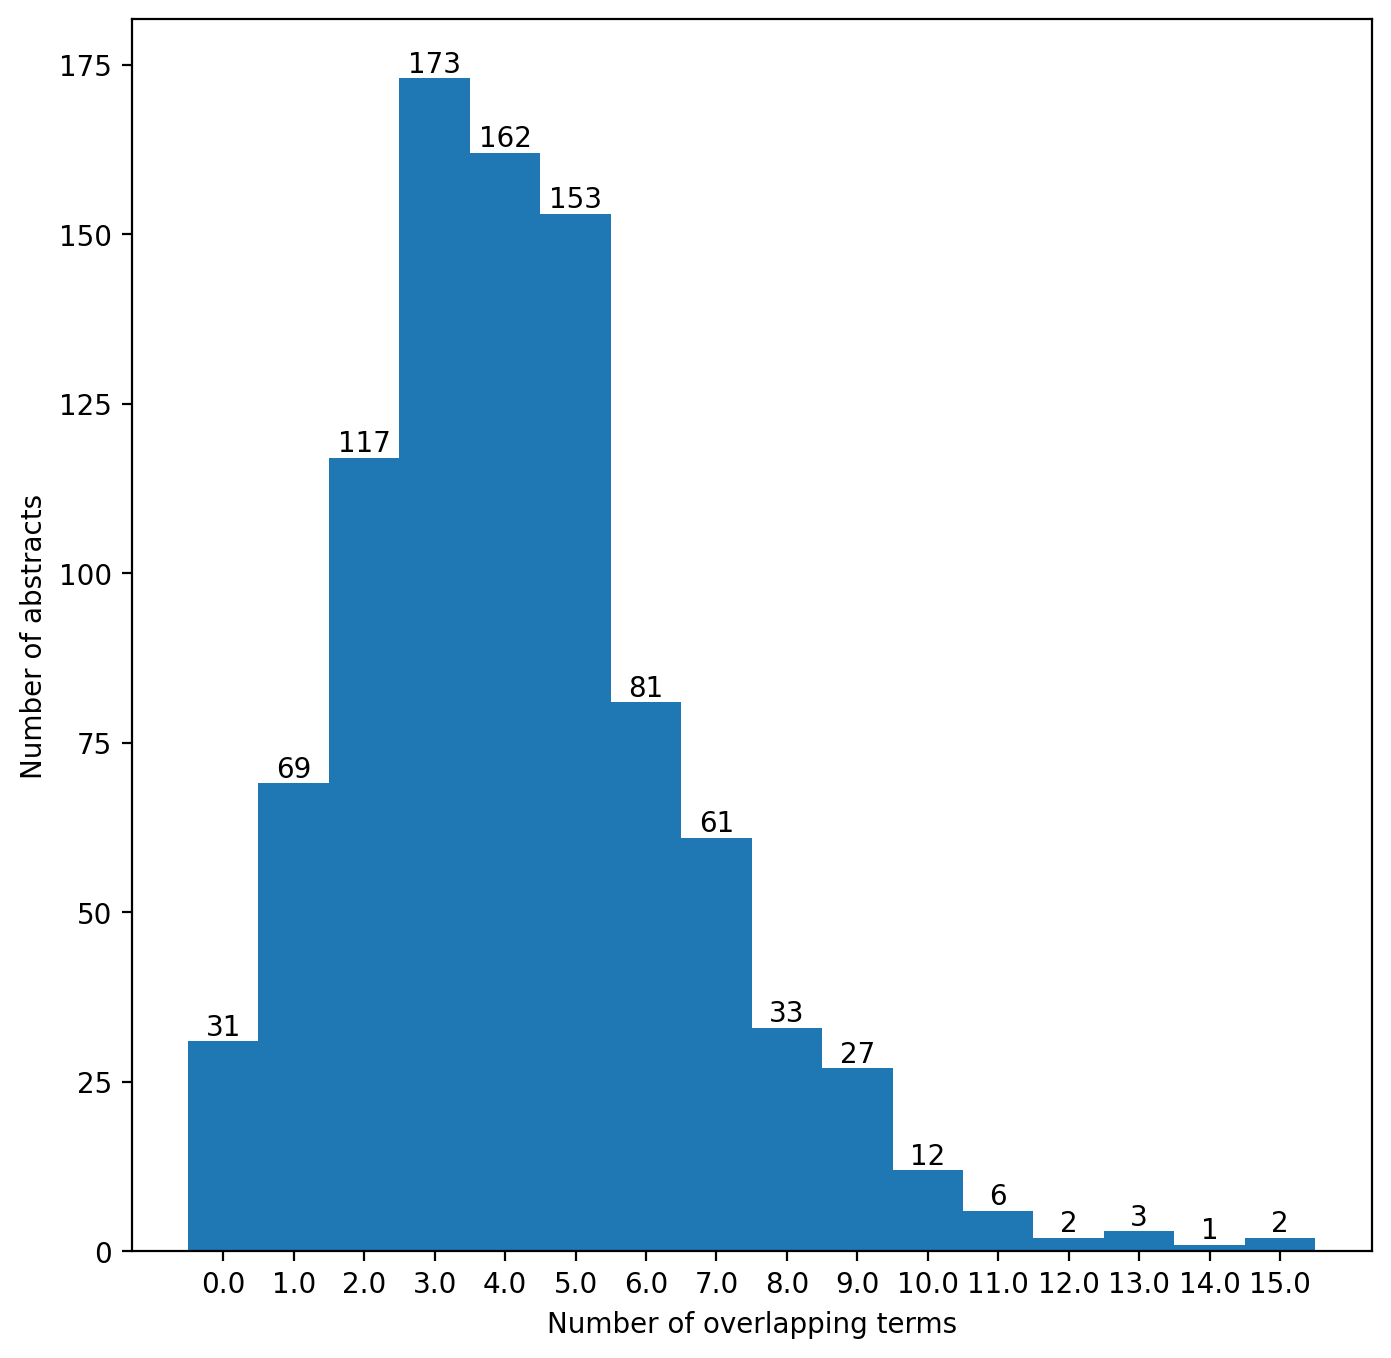

Number of papers with over 10 keywords: 280


In [80]:
# TASK 5
# Parse the output files, find possible overlapping medical terms
import pandas as pd
import os
folder = cfg.abstracts_ctakes_parsed_folder
folder_keywords = cfg.keywords_folder
medical_terms = {}
keywords = {}
over_ten_keywords = 0
for filename in os.listdir(folder):
    # Files is a .csv file, open with pandas
    df = pd.read_csv(f"{folder}/{filename}")
    # Take out the .csv extension from filename, which has multiple dots
    filename = filename.replace(".csv", "")
    # Get the medical terms
    # Headers are conditional,confidence,cui,generic,id,negated,pos_end,pos_start,preferred_text,refsem,scheme,score,subject,textsem,tui,uncertainty,true_text,part_of_speech
    # Get the preferred text
    preferred_texts = df["preferred_text"].values
    # Add the medical terms to the list. Only take unique values
    found_values = []
    for text in preferred_texts:
        if filename not in medical_terms:
            medical_terms[filename] = []
        if text not in found_values:
            found_values.append(text)
            text = preprocess_words(text)
            for word in text:
                medical_terms[filename].append(word)
for filename in os.listdir(folder_keywords):
    # Read the file
    with open(f"{folder_keywords}/{filename}") as f:
        text = f.read()
        found_values = []
        text = preprocess_words(text)
        if len(text) > 10:
            over_ten_keywords += 1
        for keyword in text:
            if filename not in keywords:
                keywords[filename] = []
            keywords[filename].append(keyword)

#Iterate through each file, and find the overlapping medical terms between the abstract and the keywords
abstracts_with_overlapping_terms = 0
total_abstracts = len(medical_terms)
n_o_overlapping_terms = []
for filename, medical_terms1 in medical_terms.items():
    # Get the keywords
    keywords_file = keywords[filename]
    # Find the overlapping medical terms
    overlapping_terms = []
    for medical_term in medical_terms1:
        if medical_term in keywords_file and medical_term not in overlapping_terms:
            overlapping_terms.append(medical_term)
    if len(overlapping_terms) > 0:
        abstracts_with_overlapping_terms += 1
    n_o_overlapping_terms.append(len(overlapping_terms))

print("Found {0} abstracts with overlapping medical terms out of {1} abstracts".format(abstracts_with_overlapping_terms, total_abstracts))
# Create a histogram of the number of overlapping terms
plt.figure(figsize=(8, 8))
counts, edges, bars = plt.hist(n_o_overlapping_terms, bins=range(0, max(n_o_overlapping_terms) + 1))
plt.bar_label(bars)
# Make sure xticks are at the center of the bars
plt.xticks(edges[:-1] + 0.5, edges[:-1])
plt.xlabel("Number of overlapping terms")
plt.ylabel("Number of abstracts")
plt.show()
# Print number of papers with over 10 keywords
print("Number of papers with over 10 keywords: " + str(over_ten_keywords))

In [21]:
# TASK 6
# Wordnet categorization for individual medical terminology
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
def calculate_sentiment_score_for_term(testw):
    synsets = wn.synsets(testw)
    # Use sentiwordnet to get the sentiment of each hyponym
    # Get the sentiments for each hyponym
    if len(synsets) == 0:
        return 0
    primary = synsets[0]
    overall_score = 0
    evaluated_words = []
    # Add the word itself to the list of evaluated words, along with all hyponyms
    evaluated_words.append(primary)
    for hyponym in primary.hyponyms():
        evaluated_words.append(hyponym)
    for hyponym in evaluated_words:
        # print(hyponym.name())
        # Get positive and negative scores, add them together and divide by 2
        pos = swn.senti_synset(hyponym.name()).pos_score()
        neg = swn.senti_synset(hyponym.name()).neg_score()
        neg = 0 - neg
        obj = swn.senti_synset(hyponym.name()).obj_score()
        score = (pos + neg)
        overall_score += score

    # Get the average score
    overall_score /= len(evaluated_words)
    return overall_score

# Calculate the sentiment score for all keywords
all_keywords = []
for filename, keywords in keywords.items():
    for keyword in keywords:
        if keyword not in all_keywords:
            all_keywords.append(keyword)

def calculate_wu_palmer_similarity(word1, word2):
    # Get the synsets
    synsets1 = wn.synsets(word1)
    synsets2 = wn.synsets(word2)
    # Get the similarity score for each pair of synsets
    scores = []
    for synset1 in synsets1:
        for synset2 in synsets2:
            score = synset1.wup_similarity(synset2)
            if score is not None:
                scores.append(score)
    # Get the average score
    average_score = np.mean(scores)
    return average_score
            
# Calculate the sentiment score for all keywords. Sort the keywords by their sentiment score and print the top/bottom 10
keyword_scores = {}
keyword_similarities_to_classes = {"mild": [], "moderate": [], "severe": []}
for keyword in all_keywords:
    score = calculate_sentiment_score_for_term(keyword)
    mild_score = calculate_wu_palmer_similarity(keyword, "mild")
    moderate_score = calculate_wu_palmer_similarity(keyword, "moderate")
    severe_score = calculate_wu_palmer_similarity(keyword, "severe")
    # Which class is the keyword closest to?
    if mild_score > moderate_score and mild_score > severe_score:
        keyword_similarities_to_classes["mild"].append(keyword)
    elif severe_score > mild_score and severe_score > moderate_score:
        keyword_similarities_to_classes["severe"].append(keyword)
    else:
        keyword_similarities_to_classes["moderate"].append(keyword)
    keyword_scores[keyword] = score
# Sort the keywords by their score
sorted_keywords = sorted(keyword_scores.items(), key=lambda x: x[1])
# Separate sorted keywords into three groups, <0 = severe, 0 = moderate, >0 = mild
keywords_moderate = []
keywords_severe = []
for keyword in sorted_keywords:
    if keyword[1] < 0:
        keywords_severe.append(keyword[0])
    elif keyword[1] >= 0:
        keywords_moderate.append(keyword[0])

# Get the overlap between the classes from the two sources with intersection
overlap_severe = list(set(keywords_severe).intersection(keyword_similarities_to_classes["severe"]))
overlap_moderate = list(set(keywords_moderate).intersection(keyword_similarities_to_classes["moderate"]))
overlap_mild = list(set(keywords_moderate).intersection(keyword_similarities_to_classes["mild"]))

c:\Users\tiitu\miniconda3\envs\AC\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\tiitu\miniconda3\envs\AC\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


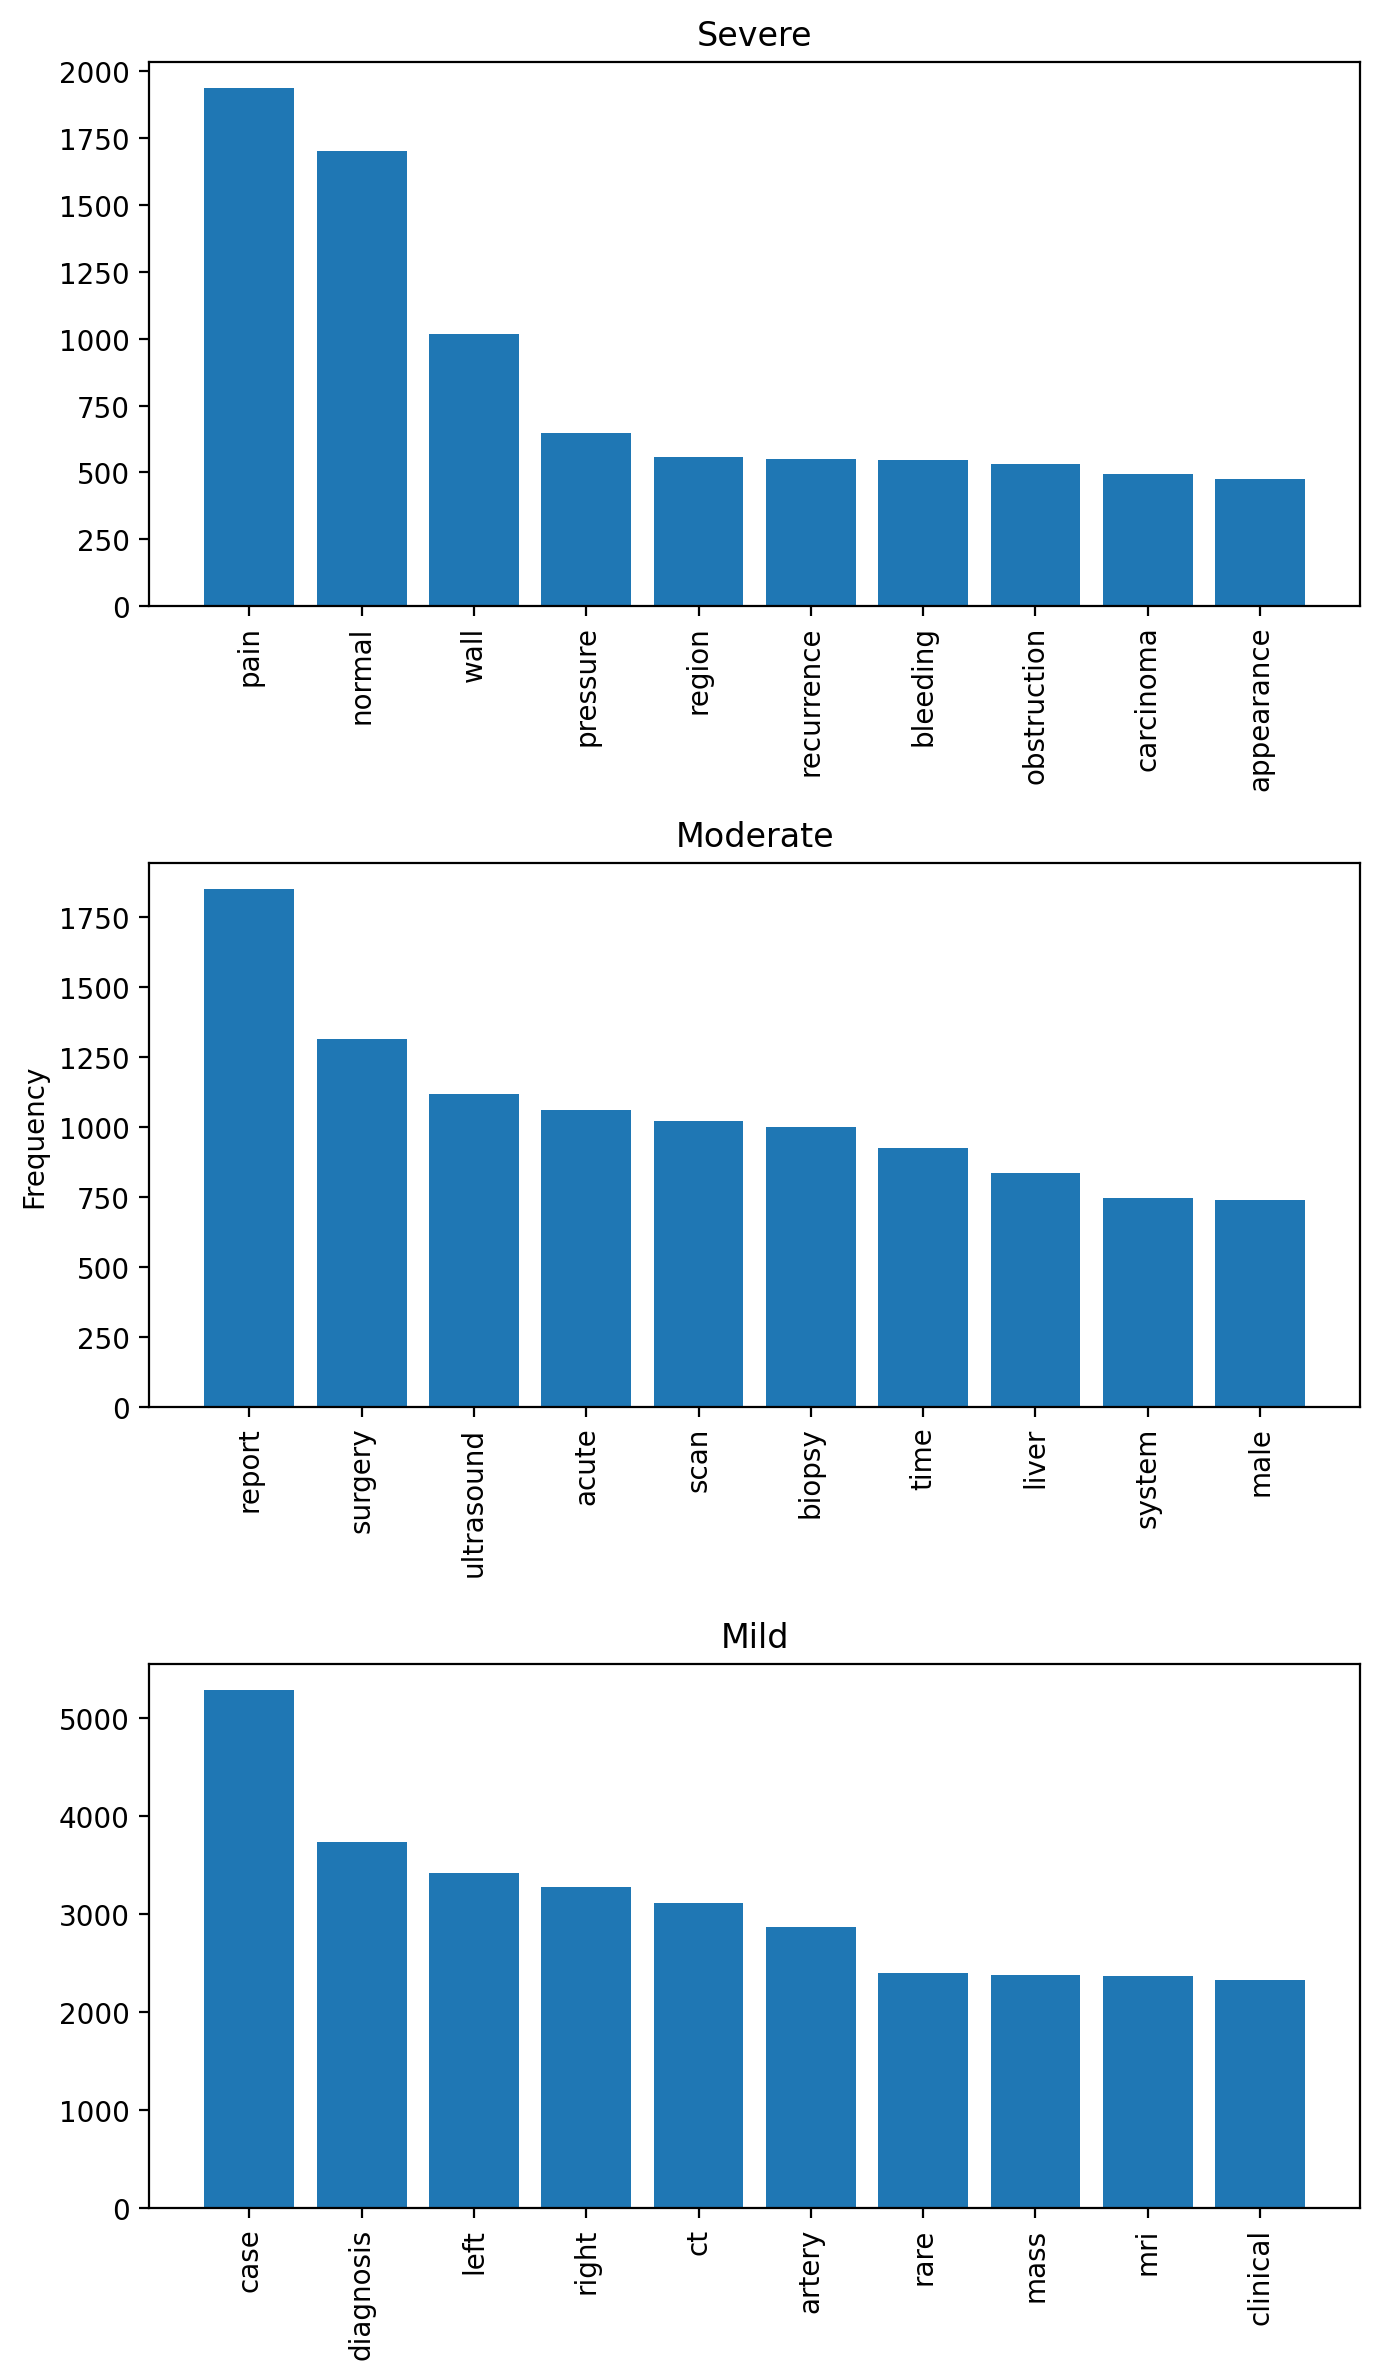

In [46]:
# TASK 6
def display_class_top_n(terms_mild, terms_moderate, terms_severe, n=10):
    # Find only medical terms that are in the overlapping classes
    medical_terms_severe = find_medical_terms(" ".join(terms_severe))
    medical_terms_moderate = find_medical_terms(" ".join(terms_mild))
    medical_terms_mild = find_medical_terms(" ".join(terms_moderate))

    # Find the frequency of each medical term in the reports
    total_corpus = []
    for filename in os.listdir(cfg.totaltext_folder):
        with open(f"{cfg.totaltext_folder}/{filename}") as f:
            text = f.read()
            total_corpus.append(text)
    # Find the frequency of each word
    from collections import Counter
    total_corpus = " ".join(total_corpus)
    total_corpus = preprocess_words(total_corpus)
    counts = Counter(total_corpus)
    # Find the frequency of each medical term in the total corpus for each class
    counts_severe = Counter()
    counts_moderate = Counter()
    counts_mild = Counter()
    for term in medical_terms_severe:
        counts_severe[term] = counts[term]
    for term in medical_terms_moderate:
        counts_moderate[term] = counts[term]
    for term in medical_terms_mild:
        counts_mild[term] = counts[term]
    # Get the top n most frequent medical terms in each class, turn back into a dictionary
    counts_severe = dict(counts_severe.most_common(n))
    counts_moderate = dict(counts_moderate.most_common(n))
    counts_mild = dict(counts_mild.most_common(n))
    # Show the top n most frequent medical terms in each class in a histogram, with word on the x axis and frequency on the y axis
    plt.figure(figsize=(7, 12))
    plt.subplot(3, 1, 1)
    plt.bar(counts_severe.keys(), counts_severe.values())
    plt.xticks(rotation=90)
    plt.title("Severe")
    plt.subplot(3, 1, 2)
    plt.bar(counts_moderate.keys(), counts_moderate.values())
    plt.xticks(rotation=90)
    plt.ylabel("Frequency")
    plt.title("Moderate")
    plt.subplot(3, 1, 3)
    plt.bar(counts_mild.keys(), counts_mild.values())
    plt.xticks(rotation=90)
    plt.title("Mild")
    plt.tight_layout()
    plt.show()

display_class_top_n(overlap_mild, overlap_moderate, overlap_severe, n=10)

In [42]:
# TASK 6
# Go through the total text files, and find the medical terms associated with diseases, signs or symptoms
total_terms = []
subjects = []
for filename in os.listdir(cfg.totaltext_ctakes_parsed_folder):
    # Read the file
    textsems = ["DiseaseDisorderMention", "SignSymptomMention"]
    # Load with pandas
    df = pd.read_csv(f"{cfg.totaltext_ctakes_parsed_folder}/{filename}")
    # Get all rows that have a textsem in the list
    df = df[df["textsem"].isin(textsems)]
    # Add subjects to the list
    subjects.append(df["subject"].values)
    # Get the preferred text
    preferred_texts = df["preferred_text"].values
    # Add the medical terms to the list. Only take unique values
    for text in preferred_texts:
        if text not in total_terms:
            total_terms.append(text)

# Print frequency of each subject
subjects = [item for sublist in subjects for item in sublist]
from collections import Counter
counter = Counter(subjects)
print(counter)


Counter({'patient': 195223, 'family_member': 80, 'other': 2})


In [24]:
# TASK 6
from gensim.models import Word2Vec
# Train word2vec on the entire totaltext sentences.
## Tokenize the sentences with nltk
sentences = []
progress = 0
total_abstracts = len(os.listdir(cfg.totaltext_folder))
for filename in os.listdir(cfg.totaltext_folder):
    # Read the file
    with open(f"{cfg.totaltext_folder}/{filename}") as f:
        text = f.read()
        # Tokenize the sentences
        words = find_medical_terms(text)
        sentences.append(words)
    if progress % 20 == 0:
        print("Progress: " + str(progress) + "/" + str(total_abstracts))
    progress += 1
print("Done!")
## Train the model
model = Word2Vec(sentences, vector_size=100, window=6, min_count=5, workers=4, sg=2)

Progress: 0/933
Progress: 20/933
Progress: 40/933
Progress: 60/933
Progress: 80/933
Progress: 100/933
Progress: 120/933
Progress: 140/933
Progress: 160/933
Progress: 180/933
Progress: 200/933
Progress: 220/933
Progress: 240/933
Progress: 260/933
Progress: 280/933
Progress: 300/933
Progress: 320/933
Progress: 340/933
Progress: 360/933
Progress: 380/933
Progress: 400/933
Progress: 420/933
Progress: 440/933
Progress: 460/933
Progress: 480/933
Progress: 500/933
Progress: 520/933
Progress: 540/933
Progress: 560/933
Progress: 580/933
Progress: 600/933
Progress: 620/933
Progress: 640/933
Progress: 660/933
Progress: 680/933
Progress: 700/933
Progress: 720/933
Progress: 740/933
Progress: 760/933
Progress: 780/933
Progress: 800/933
Progress: 820/933
Progress: 840/933
Progress: 860/933
Progress: 880/933
Progress: 900/933
Progress: 920/933
Done!


c:\Users\tiitu\miniconda3\envs\AC\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\tiitu\miniconda3\envs\AC\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Mild terms: 1743
Moderate terms: 1742
Severe terms: 1747


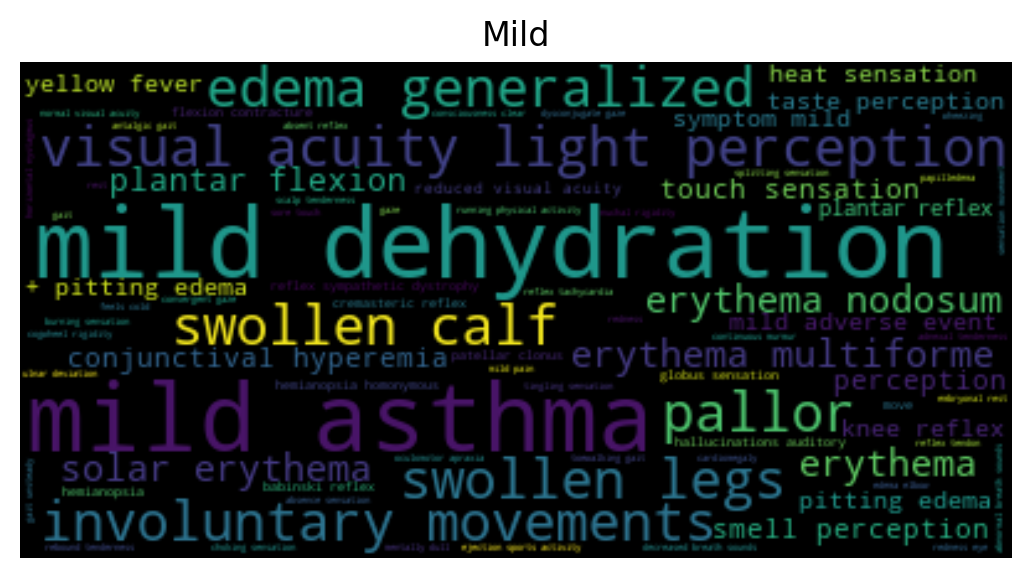

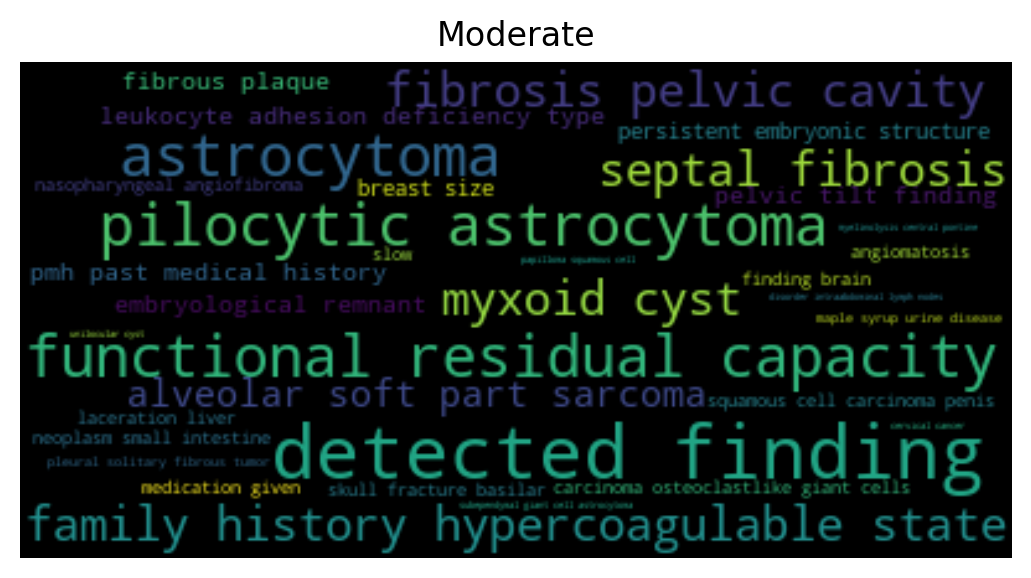

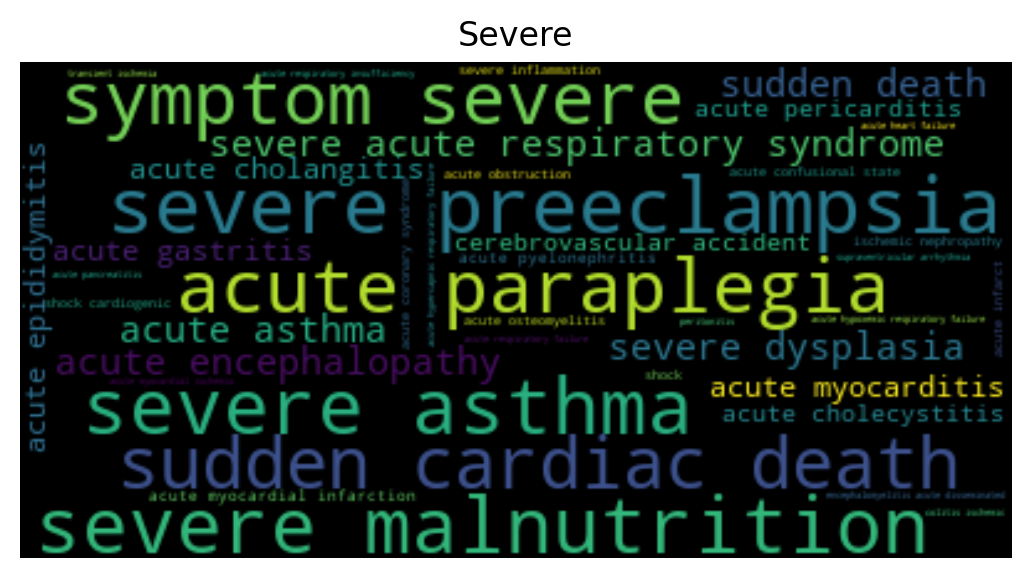

In [62]:
# TASK 6
# As opposed to the simple histogram count above, this function includes the most similar wordings, expects tuples of (word, similarity)
def display_class_with_similarity(terms_mild, terms_moderate, terms_severe, n=10, wordcloud=False):
    # Order each list by similarity
    terms_mild = sorted(terms_mild, key=lambda x: x[1], reverse=True)
    terms_moderate = sorted(terms_moderate, key=lambda x: x[1], reverse=True)
    terms_severe = sorted(terms_severe, key=lambda x: x[1], reverse=True)

    if wordcloud:
        # Create wordclouds for each class, using the similarity as the weight
        # Mild
        wordcloud = WordCloud().generate_from_frequencies(dict(terms_mild))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title("Mild")
        plt.show()
         
        # Moderate
        wordcloud = WordCloud().generate_from_frequencies(dict(terms_moderate))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title("Moderate")
        plt.show()
        
        # Severe
        wordcloud = WordCloud().generate_from_frequencies(dict(terms_severe))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title("Severe")
        plt.show()
    else:
        # Limit the lists to n terms
        terms_mild = terms_mild[:n]
        terms_moderate = terms_moderate[:n]
        terms_severe = terms_severe[:n]

        # To fix too long x axis labels, split the labels into multiple lines with \n
        # Mild
        terms_mild = [(term[0].replace(" ", "\n"), term[1]) for term in terms_mild]
        # Moderate
        terms_moderate = [(term[0].replace(" ", "\n"), term[1]) for term in terms_moderate]
        # Severe
        terms_severe = [(term[0].replace(" ", "\n"), term[1]) for term in terms_severe]
        
        # Show histograms for each class
        plt.figure(figsize=(8, 12))
        plt.subplot(3, 1, 1)
        plt.bar([term[0] for term in terms_severe], [term[1] for term in terms_severe])
        # Set the subplot scaling to min/max of the severe term similarities, with a 10% margin
        plt.ylim(min([term[1] for term in terms_severe]) * 0.9, max([term[1] for term in terms_severe]))
        plt.xticks(rotation=90)
        plt.title("Severe")
        plt.subplot(3, 1, 2)
        plt.bar([term[0] for term in terms_moderate], [term[1] for term in terms_moderate])
        print(plt.ylim(min([term[1] for term in terms_moderate]) * 0.99, max([term[1] for term in terms_moderate])))
        plt.xticks(rotation=90)
        plt.ylabel("Similarity")
        plt.title("Moderate")
        plt.subplot(3, 1, 3)
        plt.bar([term[0] for term in terms_mild], [term[1] for term in terms_mild])
        plt.ylim(min([term[1] for term in terms_mild]) * 0.9, max([term[1] for term in terms_mild]))
        plt.xticks(rotation=90)
        plt.title("Mild")
        plt.tight_layout()
        plt.show()

# Go over the terms, and get word2vec vector for each one. Take the average and get the most similar to "mild", "moderate" and "severe"
similar_words = []
mild_wv = model.wv["mild"]
moderate_wv = model.wv["moderate"]
severe_wv = model.wv["severe"]
for term in total_terms:
    vectors = []
    words = preprocess_words(term)
    for word in words:
        if word in model.wv:
            vectors.append(model.wv[word])
    # Get the average vector
    average_vector = np.mean(vectors, axis=0)
    # Get the similarity with "mild"
    try:
        # Cosine similarity
        mild_similarity = np.dot(average_vector, mild_wv) / (np.linalg.norm(average_vector) * np.linalg.norm(mild_wv))
        severe_similarity = np.dot(average_vector, severe_wv) / (np.linalg.norm(average_vector) * np.linalg.norm(severe_wv))
        # Add the term to the list of similar word 
        term = [term, (mild_similarity, severe_similarity)]
        if mild_similarity == np.nan or severe_similarity == np.nan:
            continue
        similar_words.append(term)
    except:
        continue

# Now, since we have mild-severe pairs in the similar words list, we want to divide them into three groups OF EQUAL SIZE: mild, moderate and severe based on the score
# The most similar to mild are mild, the most similar to severe are severe, and the rest are moderate
# Sort the list of similar words by their mild score
third = len(similar_words)//3
similar_words.sort(key=lambda x: x[1][0], reverse=True)
# Get the first 1/3 of the list
mild = similar_words[:third]
# Cut the list
similar_words = similar_words[third:]
# Sort the list of similar words by their severe score
similar_words.sort(key=lambda x: x[1][1], reverse=True)
# Get the first 1/3 of the list
severe = similar_words[:third]
# Cut the list
similar_words = similar_words[third:]
# Reverse the list to get the ordered list of moderate words
similar_words.reverse()
moderate = similar_words
# Now, preprocess the words and get the medical terms
mild_words = []
moderate_words = []
severe_words = []
for word in mild:
    phrase = " ".join(preprocess_words(word[0]))
    mild_similarity = word[1][0]
    mild_words.append((phrase, mild_similarity))
for word in moderate:
    phrase = " ".join(preprocess_words(word[0]))
    # Moderate similarity is defined by the difference between the mild and severe similarity. The closer to 0, the more moderate
    moderate_similarity = abs(word[1][0] - word[1][1])
    moderate_similarity = 1 - moderate_similarity
    moderate_words.append((phrase, moderate_similarity))
for word in severe:
    phrase = " ".join(preprocess_words(word[0]))
    severe_similarity = word[1][1]
    severe_words.append((phrase, severe_similarity))
# Remove duplicates
mild_words = list(set(mild_words))
moderate_words = list(set(moderate_words))
severe_words = list(set(severe_words))
print("Mild terms: " + str(len(mild_words)))
print("Moderate terms: " + str(len(moderate_words)))
print("Severe terms: " + str(len(severe_words)))
display_class_with_similarity(mild_words, moderate_words, severe_words, n=10, wordcloud=True)

Mild words: ['swollen', 'movements', 'conjunctival', 'pitting', 'pallor', 'erythema', 'perception', 'acuity', 'hypoesthesia', 'reflex', 'epigastrium', 'flexion', 'hemianopsia', 'patellar', 'move', 'touch', 'eeg', 'rigidity', 'palpation', 'redness', 'rest', 'pupillary', 'plantar', 'tender', 'pupils', 'occasional', 'sensation', 'wheezing', 'periumbilical', 'tone', 'nose', 'cold', 'papilledema', 'moderate', 'cardiomegaly', 'knees', 'lying', 'gaze', 'oculomotor', 'static', 'rash', 'light', 'rated', 'dullness', 'strength', 'hypochondrium', 'percussion', 'tenderness', 'sound', 'gait', 'dull', 'exophthalmos', 'suprapubic', 'diaphoresis', 'noted', 'icterus', 'chemosis', 'tightness', 'ptosis', 'sensations', 'ecchymosis', 'pulses', 'rating', 'transit', 'resting', 'appetite', 'radiated', 'hallucinations', 'nystagmus', 'ulnar', 'tingling', 'murmur', 'dental', 'hepatomegaly', 'massage', 'guarding', 'stiffness', 'joints', 'crackles', 'fluctuating', 'reflexes', 'hip', 'forearm', 'distension', 'moveme

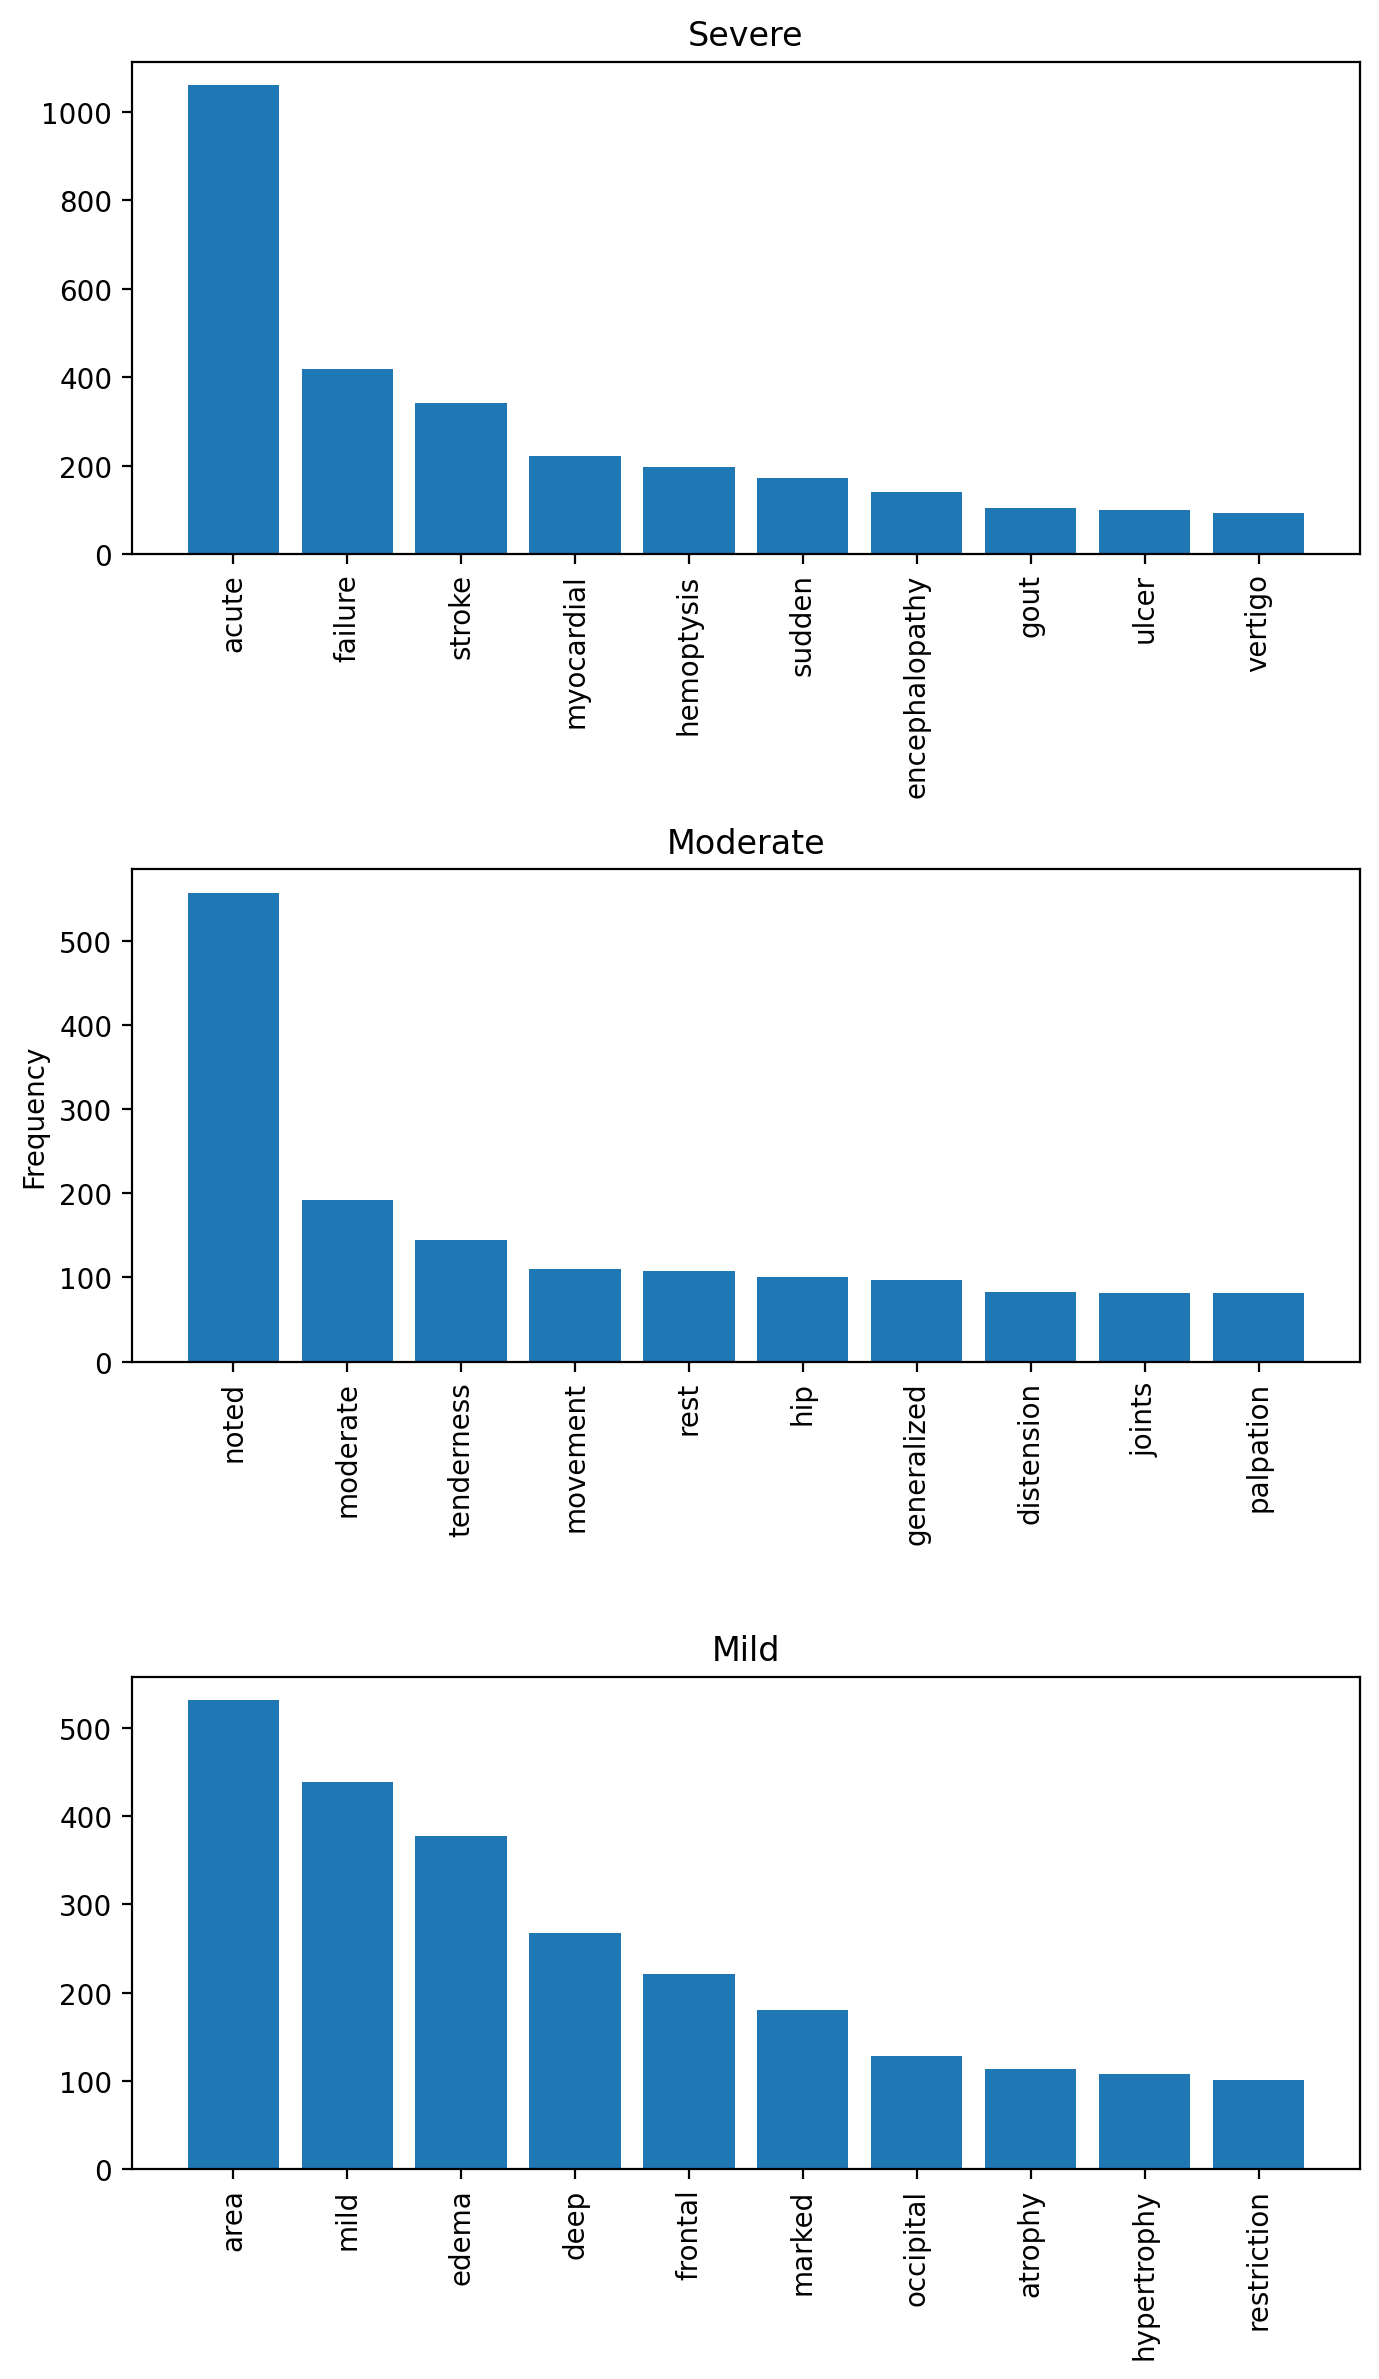

In [65]:
# TASK 6
# Get the most similar words to the word "severe"
similar_words_mild = model.wv.most_similar("mild", topn=100)
words_mild = [word[0] for word in similar_words_mild]
similar_words_moderate = model.wv.most_similar("moderate", topn=100)
words_mod = [word[0] for word in similar_words_moderate]
similar_words_severe = model.wv.most_similar("severe", topn=100)
words_sev = [word[0] for word in similar_words_severe]
# Compare the three. If overlap, leave the one with the highest score
mild_words = []
moderate_words = []
severe_words = []
for word in similar_words_mild:
    if word[0] in words_mod:
        index = words_mod.index(word[0])
        if similar_words_moderate[index][1] > word[1]:
            continue
    if word[0] in words_sev:
        index = words_sev.index(word[0])
        if similar_words_severe[index][1] > word[1]:
            continue
    mild_words.append(word[0])
for word in similar_words_moderate:
    if word[0] in words_mild:
        index = words_mild.index(word[0])
        if similar_words_mild[index][1] > word[1]:
            continue
    if word[0] in words_sev:
        index = words_sev.index(word[0])
        if similar_words_severe[index][1] > word[1]:
            continue
    moderate_words.append(word[0])
for word in similar_words_severe:
    if word[0] in words_mild:
        index = words_mild.index(word[0])
        if similar_words_mild[index][1] > word[1]:
            continue
    if word[0] in words_mod:
        index = words_mod.index(word[0])
        if similar_words_moderate[index][1] > word[1]:
            continue
    severe_words.append(word[0])

print("Mild words: " + str(mild_words))
print("Moderate words: " + str(moderate_words))
print("Severe words: " + str(severe_words))
display_class_top_n(mild_words, moderate_words, severe_words, n=10)

Mild sentences: 10902
Moderate sentences: 10783
Severe sentences: 4830
Mild negated sentences: 2846
Moderate negated sentences: 2630
Severe negated sentences: 1180


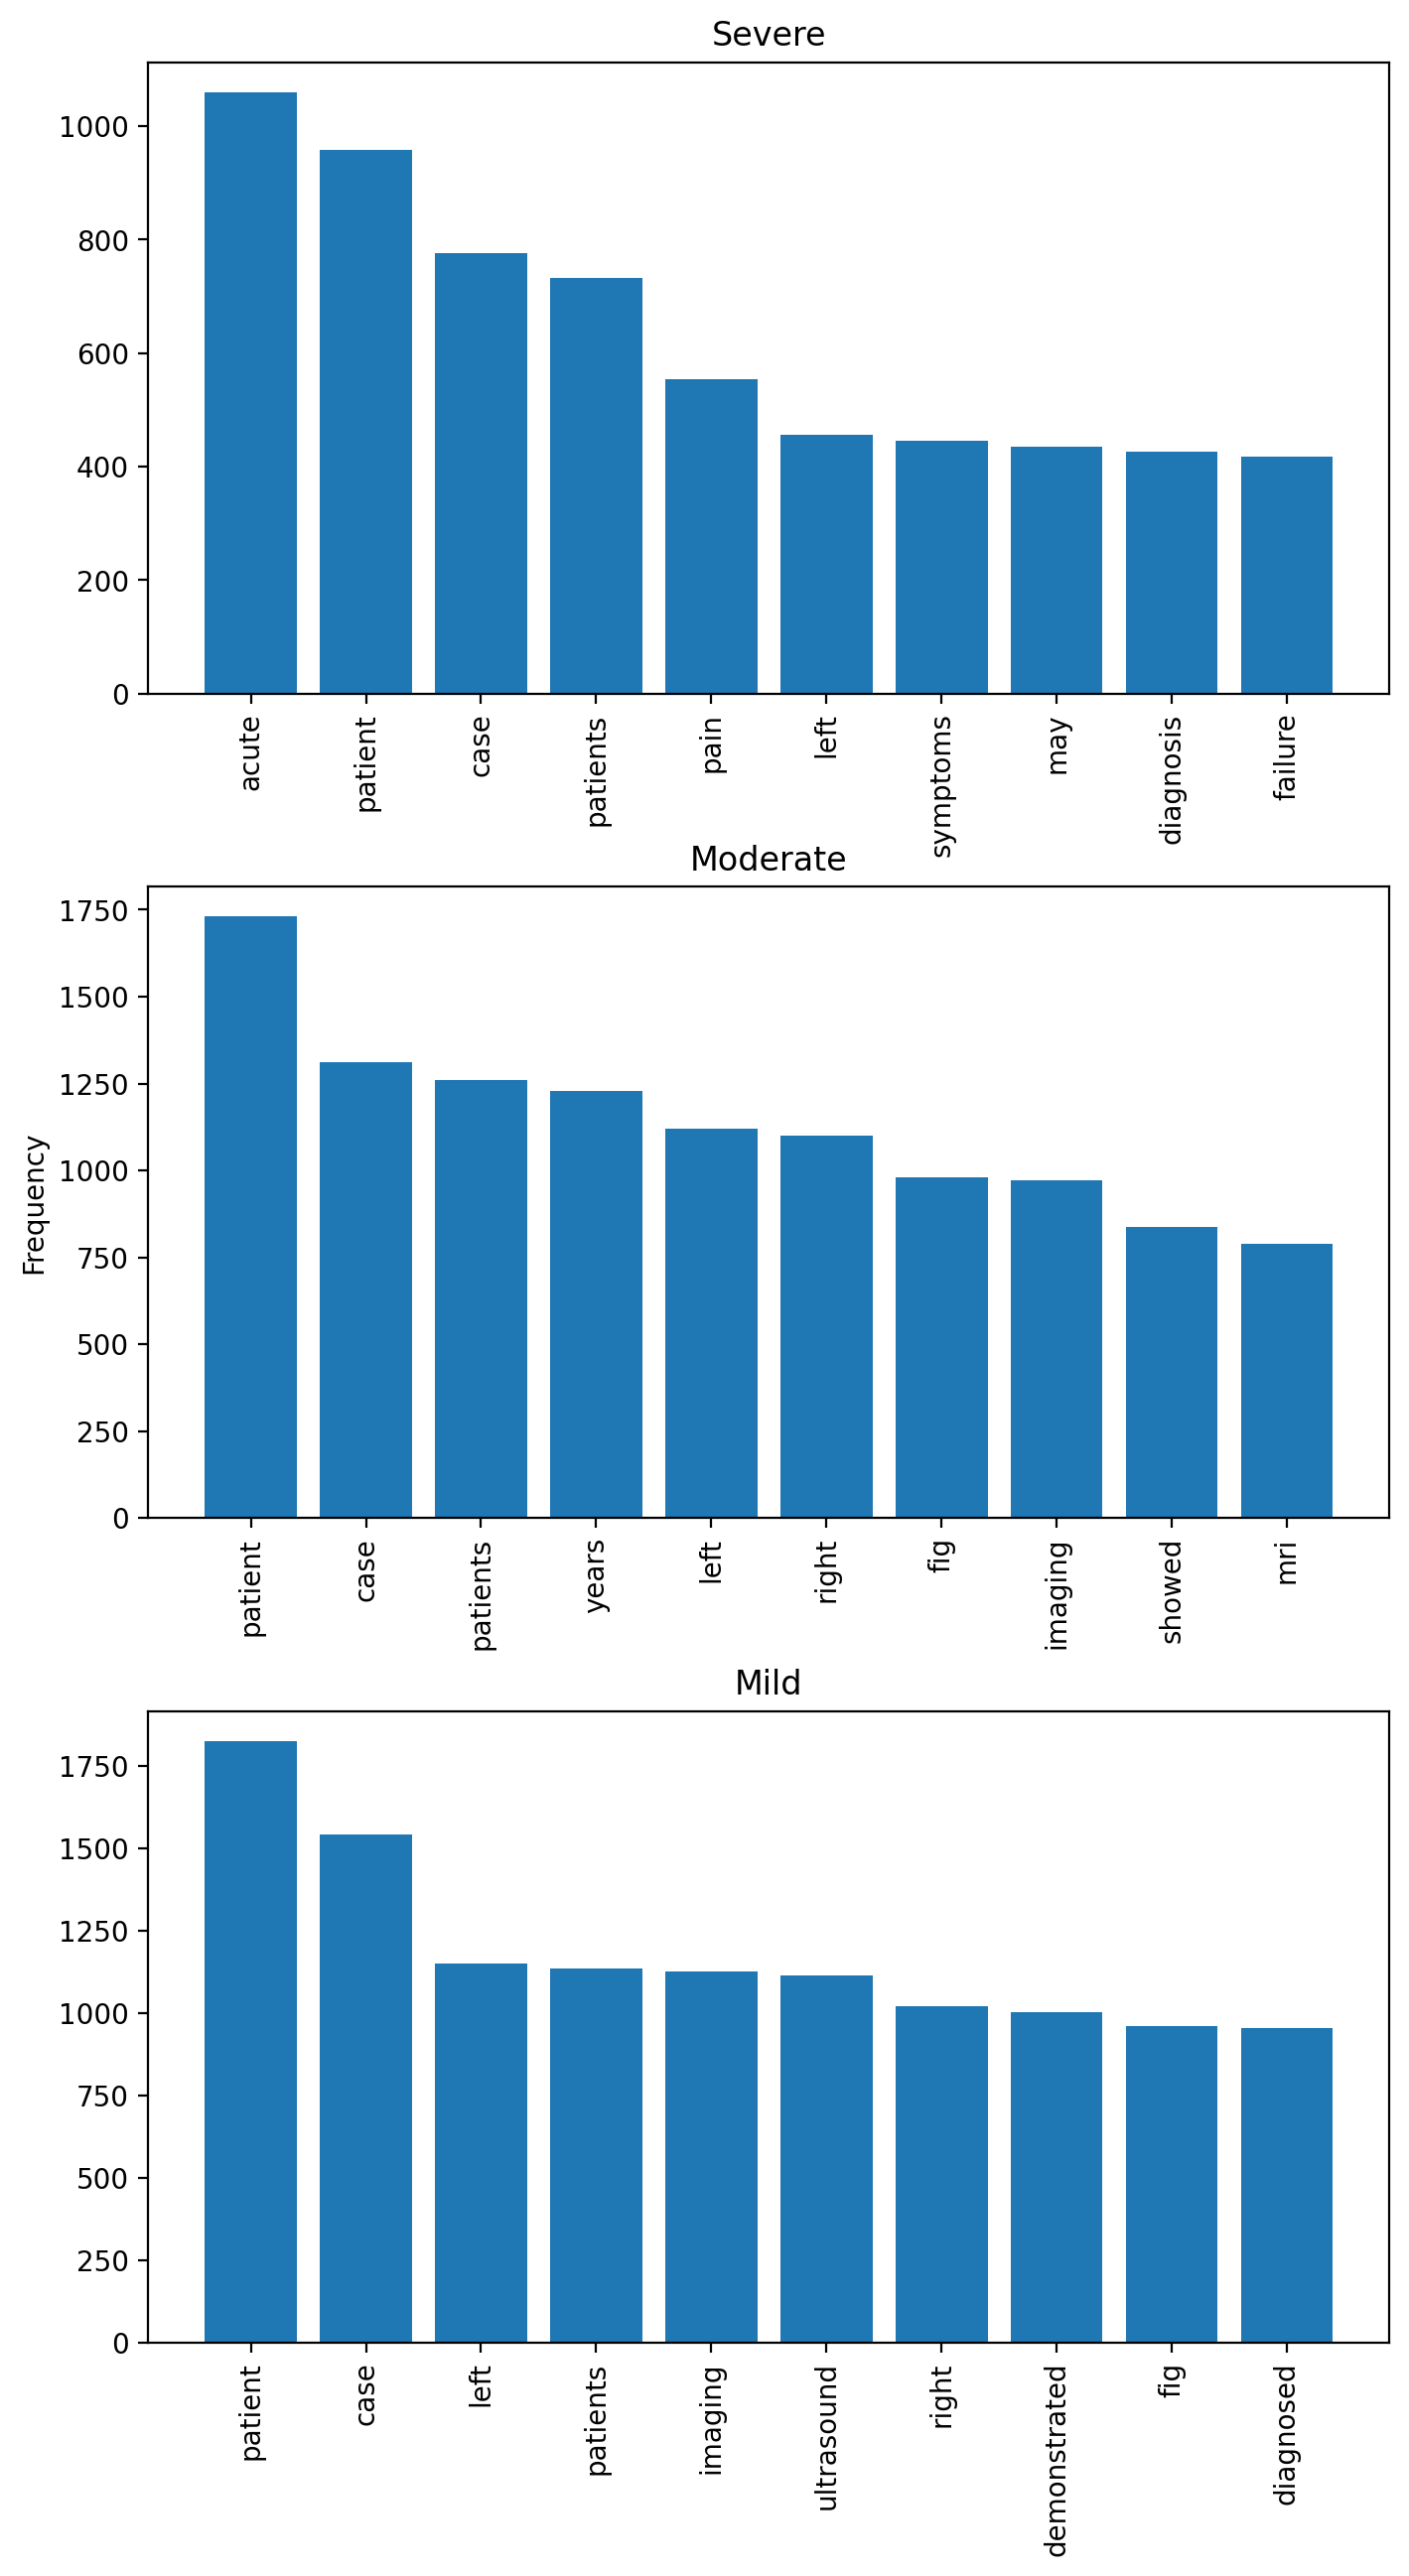

In [66]:
# TASK 7
# Find negations
negation_words = ["no", "not", "none", "without", "absent", "negative"]
# Iterate over the abstracts, and find the most frequent medical terms associated with each class 
class_sentences = {"mild": [], "moderate": [], "severe": []}
for filename in os.listdir(cfg.totaltext_folder):
    # Read the file
    with open(f"{cfg.totaltext_folder}/{filename}") as f:
        text = f.read()
        # Tokenize the sentences
        sentences = nltk.sent_tokenize(text)
        # Find whether the class words occur in the sentences. If so, add
        for sentence in sentences:
            sentence = sentence.lower()
            for word in mild_words:
                if word in sentence:
                    class_sentences["mild"].append(sentence)
            for word in moderate_words:
                if word in sentence:
                    class_sentences["moderate"].append(sentence)
            for word in severe_words:
                if word in sentence:
                    class_sentences["severe"].append(sentence)
# Filter out duplicated from all
for class_name, sentences in class_sentences.items():
    class_sentences[class_name] = list(set(sentences))
print("Mild sentences: " + str(len(class_sentences["mild"])))
print("Moderate sentences: " + str(len(class_sentences["moderate"])))
print("Severe sentences: " + str(len(class_sentences["severe"])))
# Find if negation words occur in any of them
negated_sentences = {"mild": [], "moderate": [], "severe": []}
for class_name, sentences in class_sentences.items():
    for sentence in sentences:
        # Check if the suffix -un occurs at the start of any word of the sentence
        words = sentence.split()
        for word in words:
            if word.startswith("non") or word in negation_words:
                negated_sentences[class_name].append(sentence)
print("Mild negated sentences: " + str(len(negated_sentences["mild"])))
print("Moderate negated sentences: " + str(len(negated_sentences["moderate"])))
print("Severe negated sentences: " + str(len(negated_sentences["severe"])))
# Concatenate all class sentences, find the frequency of each word, sort by frequency, and get the top 10
total_sentences_mild = " ".join(class_sentences["mild"])
total_sentences_moderate = " ".join(class_sentences["moderate"])
total_sentences_severe = " ".join(class_sentences["severe"])
# Find the frequency of each word
from collections import Counter
total_sentences_mild = preprocess_words(total_sentences_mild)
total_sentences_moderate = preprocess_words(total_sentences_moderate)
total_sentences_severe = preprocess_words(total_sentences_severe)
counts_mild = Counter(total_sentences_mild) 
counts_moderate = Counter(total_sentences_moderate) 
counts_severe = Counter(total_sentences_severe)
# Get the top 10
counts_mild = dict(counts_mild.most_common(10))
counts_moderate = dict(counts_moderate.most_common(10))
counts_severe = dict(counts_severe.most_common(10))
# Show the top n most frequent medical terms in each class in a histogram, with word on the x axis and frequency on the y axis
plt.figure(figsize=(7, 12))
plt.subplot(3, 1, 1)
plt.bar(counts_severe.keys(), counts_severe.values())
plt.xticks(rotation=90)
plt.title("Severe")
plt.tight_layout()
plt.subplot(3, 1, 2)
plt.bar(counts_moderate.keys(), counts_moderate.values())
plt.xticks(rotation=90)
plt.ylabel("Frequency")
plt.title("Moderate")
plt.subplot(3, 1, 3)
plt.bar(counts_mild.keys(), counts_mild.values())
plt.xticks(rotation=90)
plt.title("Mild")
plt.show()

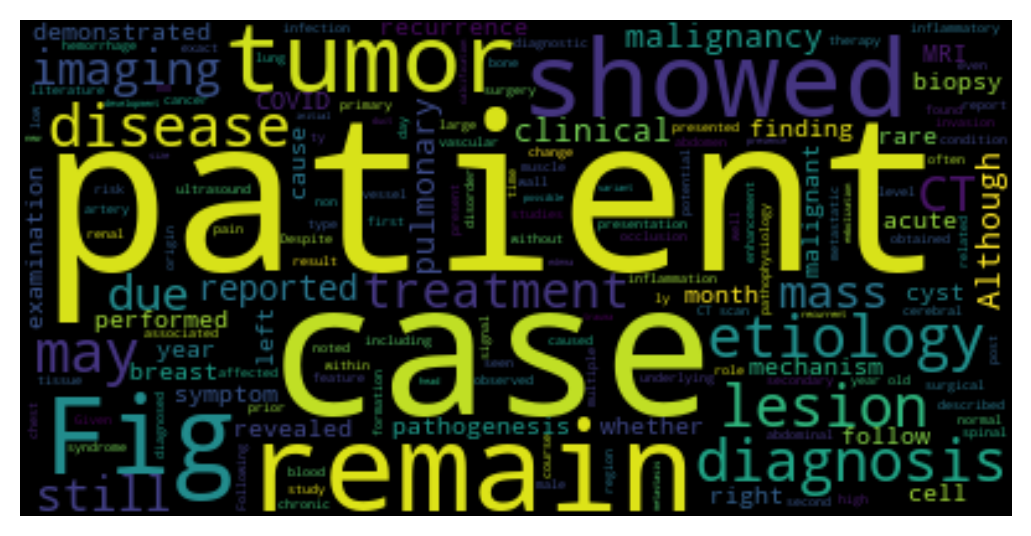

In [67]:
# TASK 8
# Suggest a set of keywords that would indicate uncertainty (e.g., “not clear”, no evidence”, “unsure”,…). Retrieve the set of statements (sentences) where the uncertainty related wording occur and concatenate all these statements to for form a single document.  Draw the WordCloud of the underlined document to visualize the most comment words. Next, extract the medical wording contained in these statements and draw the histogram showing the most diseases /treatments for which doctors feel uncertain.
uncertainty_words = ["not clear", "no evidence", "unsure", "uncertain", "unclear", "not sure", "not certain", "not clear", "not conclusive", "not definitive", "not definite", "unconclusive"]
uncertainty_sentences = []
directory = cfg.totaltext_folder
# Go over all abstracts, find the sentences that contain uncertainty words
for filename in os.listdir(directory):
    # Get the abstract
    with open(f"{directory}/{filename}") as f:
        abstract = f.read()
        # Split the abstract to sentences
        sentences = nltk.sent_tokenize(abstract)
        # Go over each sentence, find the uncertainty words
        for sentence in sentences:
            # Check if the sentence contains any of the uncertainty words
            for uncertainty_word in uncertainty_words:
                if uncertainty_word in sentence:
                    # Remove the uncertainty word from the sentence
                    sentence = sentence.replace(uncertainty_word, "")
                    uncertainty_sentences.append(sentence)
                    break
# Concatenate the sentences
uncertainty_sentences = " ".join(uncertainty_sentences)
# Draw the wordcloud
from wordcloud import WordCloud
wordcloud = WordCloud().generate(uncertainty_sentences)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

[('patient', 67), ('case', 53), ('patients', 46), ('fig', 45), ('ct', 41), ('etiology', 38), ('may', 38), ('imaging', 37), ('diagnosis', 37), ('cases', 35), ('disease', 34), ('mass', 29), ('treatment', 29), ('due', 27), ('tumor', 26), ('still', 26), ('reported', 24), ('pulmonary', 24), ('lesion', 24), ('pathogenesis', 22)]


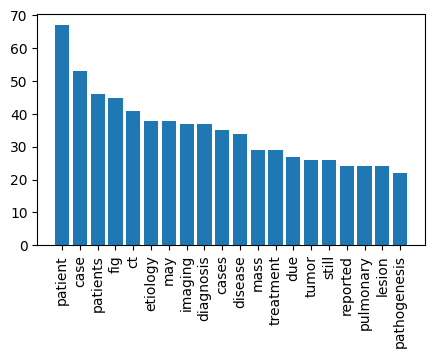

In [29]:
# TASK 8
# Next, extract the medical wording contained in these statements and draw the histogram showing the most diseases /treatments for which doctors feel uncertain.
uncertainty_medical_terms = find_medical_terms(uncertainty_sentences, preprocess=True, remove_duplicates=False)
# Show the 20 most common medical terms with a histogram
from collections import Counter
counts = Counter(uncertainty_medical_terms)
print(counts.most_common(20))
counts = counts.most_common(20)
# Back to dictionary
counts = dict(counts)
# Draw the histogram
plt.figure(figsize=(5, 3))
plt.bar(counts.keys(), counts.values())
# Scale = 2x
plt.rcParams["figure.dpi"] = 200
plt.xticks(rotation=90)
plt.show()